<a href="https://colab.research.google.com/github/seriman96/Assign/blob/main/Assign2_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1: Gridworld Without Terminal States**

####**1. Consider a reward discount of γ = 0.95 and a policy which simply moves to one of the four directions with equal probability of 0.25. Estimate the value function for each of the states using (1) solving the system of Bellman equations explicitly (2) iterative policy evaluation. Which states have the highest value? Does this surprise you?**

**Step 1: Define the environment**

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import seaborn as sns

In [37]:
# Gridworld size
GRID_SIZE = 5
NUM_STATES = GRID_SIZE * GRID_SIZE
ACTIONS = ['up', 'down', 'left', 'right']
ACTION_TO_DELTA = {
    'up': (-1, 0),
    'down': (1, 0),
    'left': (0, -1),
    'right': (0, 1),
}
GAMMA = 0.95
ACTION_PROB = 0.25  # uniform random policy

In [38]:
# Special state positions
BLUE = (0, 1)     # Blue square
GREEN = (0, 4)    # Green square
RED = (3, 2)      # Red square
YELLOW = (4, 4)   # Yellow square


# Convert (i, j) to state index
def to_index(i, j):
    return i * GRID_SIZE + j

# Reverse mapping
def to_coords(index):
    return divmod(index, GRID_SIZE)

# Check valid position
def is_valid(i, j):
    return 0 <= i < GRID_SIZE and 0 <= j < GRID_SIZE


**Step 2: Transition and Reward matrices**

In [39]:
P = np.zeros((NUM_STATES, len(ACTIONS), NUM_STATES))
R = np.zeros((NUM_STATES, len(ACTIONS)))

for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        s = to_index(i, j)

        for a_idx, a in enumerate(ACTIONS):
            if (i, j) == BLUE:
                next_s = to_index(*RED)
                R[s, a_idx] = 5.0
                P[s, a_idx, next_s] = 1.0

            elif (i, j) == GREEN:
                red_idx = to_index(*RED)
                yellow_idx = to_index(*YELLOW)
                R[s, a_idx] = 2.5
                P[s, a_idx, red_idx] = 0.5
                P[s, a_idx, yellow_idx] = 0.5

            else:
                di, dj = ACTION_TO_DELTA[a]
                ni, nj = i + di, j + dj
                if is_valid(ni, nj):
                    ns = to_index(ni, nj)
                    P[s, a_idx, ns] = 1.0
                    R[s, a_idx] = 0.0
                else:
                    # Off-grid penalty
                    P[s, a_idx, s] = 1.0
                    R[s, a_idx] = -0.5


**Step 3: (1) Solve Bellman equations directly**

In [40]:
# Compute R_pi and P_pi
R_pi = np.zeros(NUM_STATES)
P_pi = np.zeros((NUM_STATES, NUM_STATES))

for s in range(NUM_STATES):
    for a in range(len(ACTIONS)):
        R_pi[s] += ACTION_PROB * R[s, a]
        for s_prime in range(NUM_STATES):
            P_pi[s, s_prime] += ACTION_PROB * P[s, a, s_prime]

# Solve linear system: (I - γP) V = R
I = np.eye(NUM_STATES)
A = I - GAMMA * P_pi
V_bellman = np.linalg.solve(A, R_pi)

# Reshape to 5x5 grid
V_bellman_grid = V_bellman.reshape((GRID_SIZE, GRID_SIZE))
print("Value function from Bellman equation:\n", np.round(V_bellman_grid, 2))


Value function from Bellman equation:
 [[ 2.17  4.73  2.07  1.27  1.78]
 [ 1.12  1.78  1.17  0.74  0.56]
 [ 0.16  0.48  0.35  0.11 -0.19]
 [-0.55 -0.28 -0.28 -0.44 -0.74]
 [-1.11 -0.85 -0.81 -0.94 -1.24]]


**Step 4: (2) Iterative Policy Evaluation**

In [41]:
V_iter = np.zeros(NUM_STATES)
theta = 1e-5  # convergence threshold

while True:
    delta = 0
    for s in range(NUM_STATES):
        v = V_iter[s]
        v_new = 0
        for a in range(len(ACTIONS)):
            for s_prime in range(NUM_STATES):
                v_new += ACTION_PROB * P[s, a, s_prime] * (R[s, a] + GAMMA * V_iter[s_prime])
        delta = max(delta, abs(v - v_new))
        V_iter[s] = v_new
    if delta < theta:
        break

V_iter_grid = V_iter.reshape((GRID_SIZE, GRID_SIZE))
print("Value function from iterative policy evaluation:\n", np.round(V_iter_grid, 2))


Value function from iterative policy evaluation:
 [[ 2.17  4.73  2.07  1.27  1.78]
 [ 1.12  1.78  1.17  0.74  0.56]
 [ 0.16  0.48  0.35  0.11 -0.19]
 [-0.55 -0.28 -0.28 -0.44 -0.74]
 [-1.11 -0.85 -0.81 -0.94 -1.24]]


**Plotting**

In [42]:
def plot_two_value_grids(V1, V2, title1, title2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

    V1_grid = V1.reshape(GRID_SIZE, GRID_SIZE)
    V2_grid = V2.reshape(GRID_SIZE, GRID_SIZE)

    for idx, (V_grid, title) in enumerate(zip([V1_grid, V2_grid], [title1, title2])):
        ax = axes[idx]
        cax = ax.matshow(V_grid, cmap='coolwarm')
        ax.set_title(title)

        # Find max value and its positions
        max_value = np.max(V_grid)
        max_positions = np.argwhere(V_grid == max_value)

        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                ax.text(j, i, f"{V_grid[i, j]:.2f}", ha='center', va='center', fontsize=9)

        # Highlight max cell(s)
        for pos in max_positions:
            rect = plt.Rectangle((pos[1] - 0.5, pos[0] - 0.5), 1, 1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

        # Print summary for this grid
        coords = [tuple(map(int, p)) for p in max_positions]
        print(f"🌟 {title}: Max value = {max_value:.2f} at state(s): {coords}")

        ax.set_xticks(np.arange(GRID_SIZE))
        ax.set_yticks(np.arange(GRID_SIZE))
        ax.invert_yaxis()

    fig.colorbar(cax, ax=axes.ravel().tolist(), shrink=0.75)
    plt.show()


In [43]:
def extract_greedy_policy(V, P, R, gamma=0.95):
    policy = np.zeros(NUM_STATES, dtype=int)
    for s in range(NUM_STATES):
        action_values = []
        for a in range(len(ACTIONS)):
            q_sa = 0
            for s_prime in range(NUM_STATES):
                q_sa += P[s, a, s_prime] * (R[s, a] + gamma * V[s_prime])
            action_values.append(q_sa)
        policy[s] = np.argmax(action_values)
    return policy


🌟 Value Function (Bellman Equation): Max value = 4.73 at state(s): [(0, 1)]
🌟 Value Function (Iterative Policy Evaluation): Max value = 4.73 at state(s): [(0, 1)]


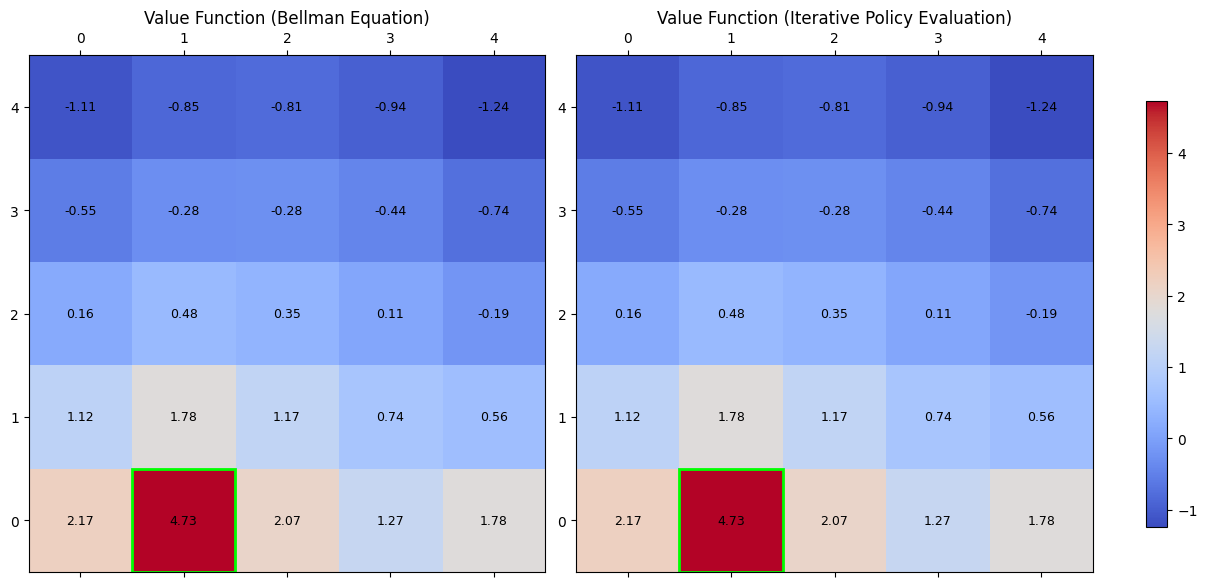

In [44]:
plot_two_value_grids(V_bellman, V_iter,
                     "Value Function (Bellman Equation)",
                     "Value Function (Iterative Policy Evaluation)")


In [45]:
def plot_two_policies(policy1, policy2, title1, title2):
    arrow_map = {0: '↑', 1: '↓', 2: '←', 3: '→'}

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

    for idx, (policy, title) in enumerate(zip([policy1, policy2], [title1, title2])):
        ax = axes[idx]
        grid = np.array([arrow_map[a] for a in policy]).reshape(GRID_SIZE, GRID_SIZE)

        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                ax.text(j, i, grid[i, j], ha='center', va='center', fontsize=14)

        # Annotate special states
        special_labels = {
            BLUE: 'BLUE',
            GREEN: 'GREEN',
            RED: 'RED',
            YELLOW: 'YELLOW'
        }
        for (i, j), label in special_labels.items():
            ax.text(j, i, label, ha='center', va='bottom', fontsize=8, color='blue')

        ax.set_title(title)
        ax.set_xticks(np.arange(GRID_SIZE))
        ax.set_yticks(np.arange(GRID_SIZE))
        ax.invert_yaxis()

    plt.show()


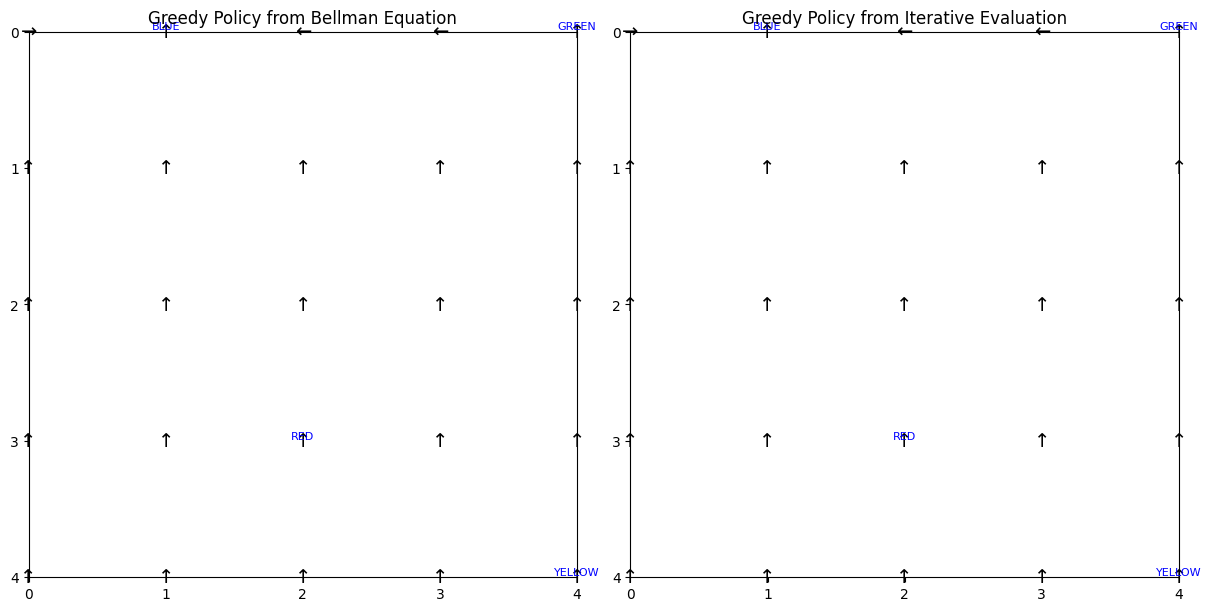

In [46]:
pi_bellman = extract_greedy_policy(V_bellman, P, R)
pi_iter = extract_greedy_policy(V_iter, P, R)

plot_two_policies(
    pi_bellman, pi_iter,
    "Greedy Policy from Bellman Equation",
    "Greedy Policy from Iterative Evaluation"
)


##### **"Which states have the highest value? Does this surprise you?"**


The highest value was found at state (0, 1), which is the blue square.
This is not surprising, since this state gives an immediate reward of +5 and teleports the agent to another high-reward region (red).
It's a natural target under a random policy, as even random movement eventually leads to high return from this state.

####**2. Determine the optimal policy for the gridworld problem by (1) explicitly solving the Bellman optimality equation (2) using policy iteration with iterative policy evaluation (3) policy improvement with value iteration.**

**Step 1.2 — Find Optimal Policy**

**(1) Bellman Optimality Equation (via value iteration to convergence)**

In [47]:
def bellman_optimality_value_iteration(P, R, gamma=0.95, theta=1e-5):
    V = np.zeros(NUM_STATES)
    while True:
        delta = 0
        for s in range(NUM_STATES):
            v = V[s]
            action_values = []
            for a in range(len(ACTIONS)):
                q_sa = 0
                for s_prime in range(NUM_STATES):
                    q_sa += P[s, a, s_prime] * (R[s, a] + gamma * V[s_prime])
                action_values.append(q_sa)
            V[s] = max(action_values)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    policy = extract_greedy_policy(V, P, R, gamma)
    return V, policy

V_opt_bellman, pi_opt_bellman = bellman_optimality_value_iteration(P, R)


**(2) Policy Iteration**

In [48]:
def policy_iteration(P, R, gamma=0.95, theta=1e-5):
    policy = np.zeros(NUM_STATES, dtype=int)  # start with 'up'
    V = np.zeros(NUM_STATES)

    stable = False
    while not stable:
        # Policy Evaluation
        while True:
            delta = 0
            for s in range(NUM_STATES):
                a = policy[s]
                v = V[s]
                v_new = 0
                for s_prime in range(NUM_STATES):
                    v_new += P[s, a, s_prime] * (R[s, a] + gamma * V[s_prime])
                delta = max(delta, abs(v - v_new))
                V[s] = v_new
            if delta < theta:
                break

        # Policy Improvement
        stable = True
        for s in range(NUM_STATES):
            old_a = policy[s]
            action_values = []
            for a in range(len(ACTIONS)):
                q_sa = 0
                for s_prime in range(NUM_STATES):
                    q_sa += P[s, a, s_prime] * (R[s, a] + gamma * V[s_prime])
                action_values.append(q_sa)
            best_a = np.argmax(action_values)
            policy[s] = best_a
            if old_a != best_a:
                stable = False

    return V, policy

V_opt_pi, pi_opt_pi = policy_iteration(P, R)


**(3) Value Iteration**

In [49]:
def value_iteration(P, R, gamma=0.95, theta=1e-5):
    V = np.zeros(NUM_STATES)
    while True:
        delta = 0
        for s in range(NUM_STATES):
            v = V[s]
            action_values = []
            for a in range(len(ACTIONS)):
                q_sa = 0
                for s_prime in range(NUM_STATES):
                    q_sa += P[s, a, s_prime] * (R[s, a] + gamma * V[s_prime])
                action_values.append(q_sa)
            V[s] = max(action_values)
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break

    policy = extract_greedy_policy(V, P, R, gamma)
    return V, policy

V_opt_vi, pi_opt_vi = value_iteration(P, R)


**Policy Visualization**

In [50]:
def plot_comparative_value_grids(V_list, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)

    for idx, (V, title) in enumerate(zip(V_list, titles)):
        ax = axes[idx]
        V_grid = V.reshape(GRID_SIZE, GRID_SIZE)

        # Draw heatmap
        cax = ax.matshow(V_grid, cmap='coolwarm')
        ax.set_title(title)

        # Annotate values
        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                ax.text(j, i, f"{V_grid[i, j]:.1f}", ha='center', va='center', fontsize=8)

        # Highlight max value(s)
        max_val = np.max(V_grid)
        max_positions = np.argwhere(V_grid == max_val)
        for pos in max_positions:
            rect = plt.Rectangle((pos[1] - 0.5, pos[0] - 0.5), 1, 1,
                                 linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)

        ax.set_xticks(np.arange(GRID_SIZE))
        ax.set_yticks(np.arange(GRID_SIZE))
        ax.invert_yaxis()

    # Shared colorbar
    fig.colorbar(cax, ax=axes.ravel().tolist(), shrink=0.7)
    plt.show()

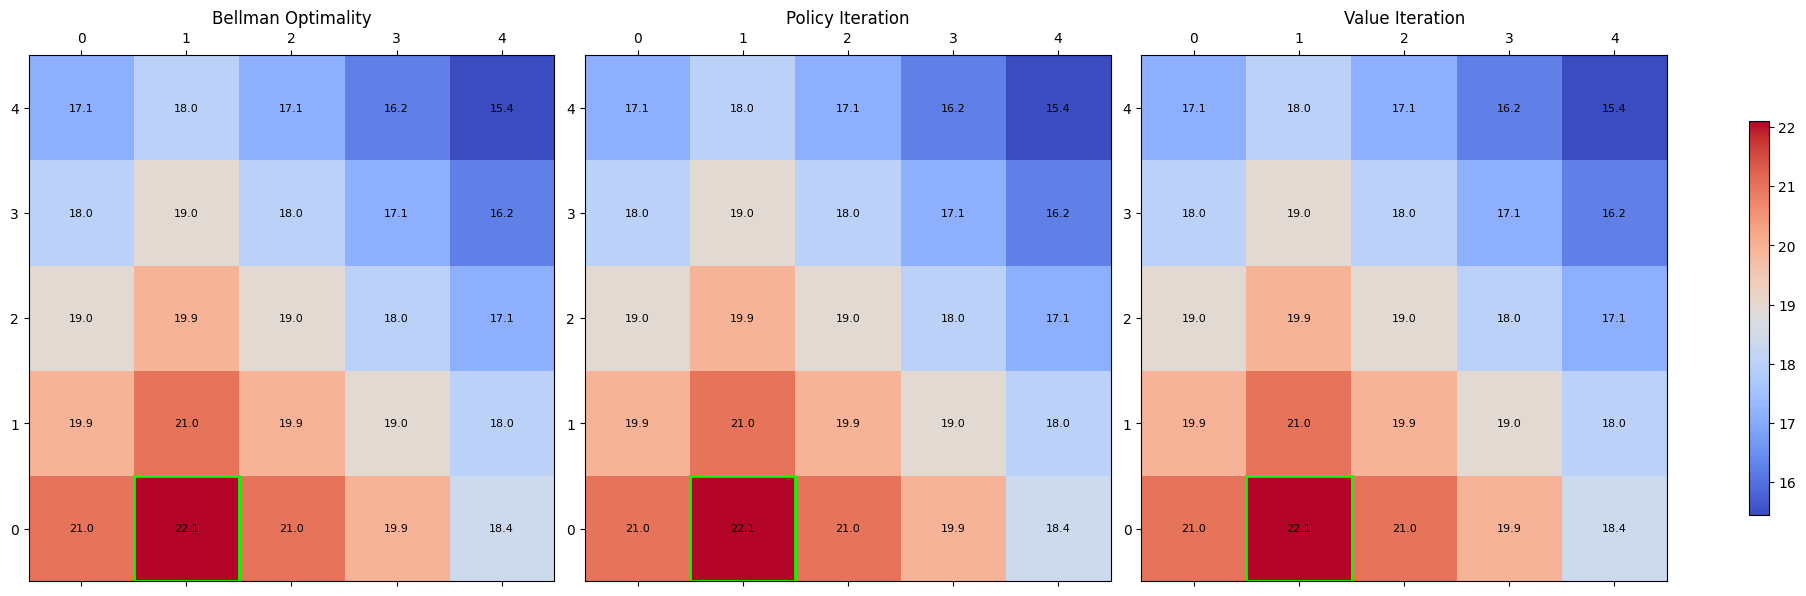

In [51]:
# Use the optimal value functions from earlier
plot_comparative_value_grids(
    [V_opt_bellman, V_opt_pi, V_opt_vi],
    ["Bellman Optimality", "Policy Iteration", "Value Iteration"]
)

In [52]:
def plot_comparative_policies(policies, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), constrained_layout=True)
    arrow_map = {0: '↑', 1: '↓', 2: '←', 3: '→'}

    for idx, (policy, title) in enumerate(zip(policies, titles)):
        ax = axes[idx]
        grid = np.array([arrow_map[a] for a in policy]).reshape(GRID_SIZE, GRID_SIZE)

        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                ax.text(j, i, grid[i, j], ha='center', va='center', fontsize=14)

        # Special state labels
        special_labels = {
            BLUE: 'BLUE',
            GREEN: 'GREEN',
            RED: 'RED',
            YELLOW: 'YELLOW'
        }
        for (i, j), label in special_labels.items():
            ax.text(j, i, label, ha='center', va='bottom', fontsize=8, color='blue')

        ax.set_title(title)
        ax.set_xticks(np.arange(GRID_SIZE))
        ax.set_yticks(np.arange(GRID_SIZE))
        ax.invert_yaxis()

    plt.show()

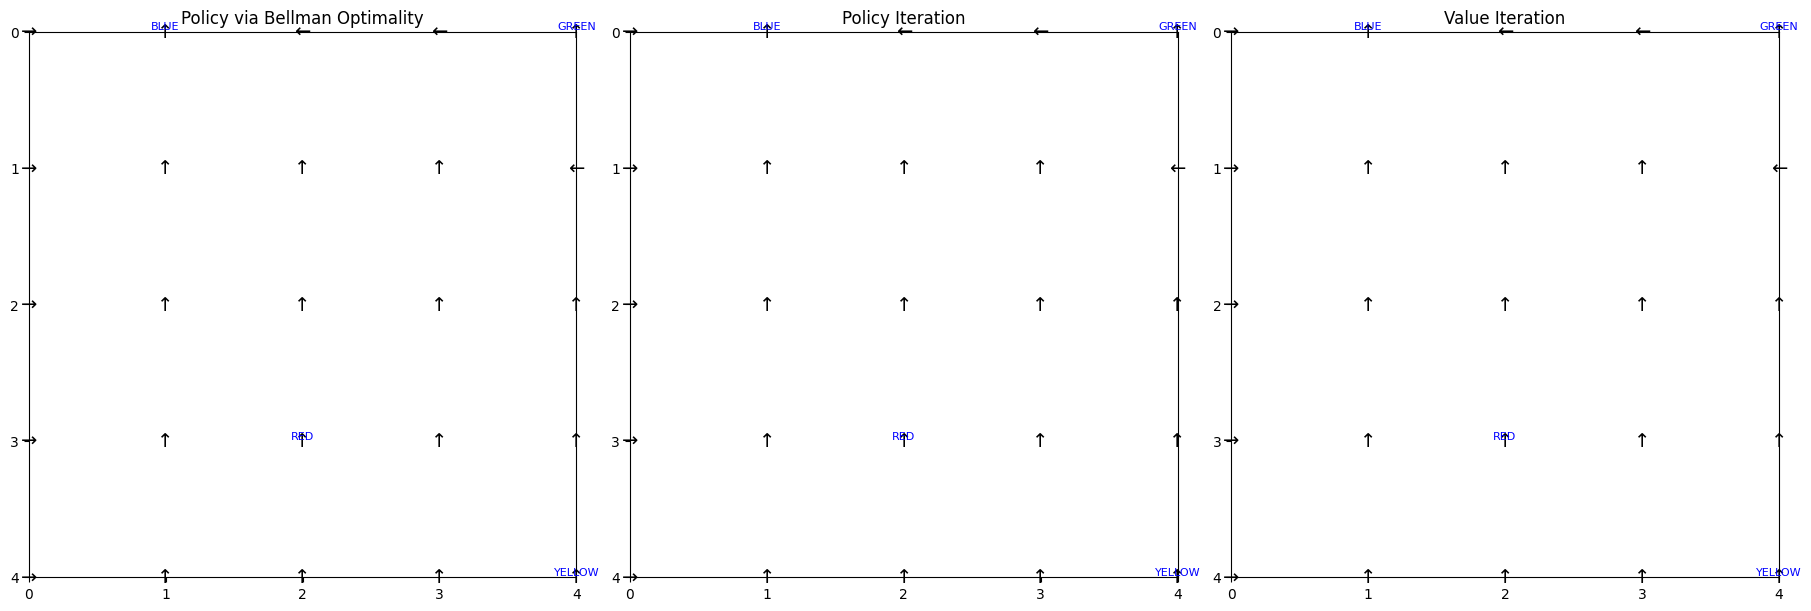

In [53]:
plot_comparative_policies(
    [pi_opt_bellman, pi_opt_pi, pi_opt_vi],
    ["Policy via Bellman Optimality", "Policy Iteration", "Value Iteration"]
)


**Clarification on Optimal Policy Methods**

In Question 2 of Part 1, we were asked to determine the optimal policy using three different approaches. While the wording might suggest all three rely on explicitly solving the Bellman optimality equation, the intended interpretation corresponds to three distinct standard methods for computing optimal policies in reinforcement learning:

Value Iteration: This method approximates the solution to the Bellman optimality equation by iteratively applying the Bellman update with a max over actions. It yields the optimal value function and the corresponding greedy policy.

Policy Iteration: This involves alternating between iterative policy evaluation (computing the value function for a fixed policy) and policy improvement (updating the policy greedily based on the current value function). This method is conceptually separate from solving the Bellman optimality equation directly.

Policy Improvement via Value Iteration: This refers again to Value Iteration, where both evaluation and improvement are combined into a single update step. This method incrementally improves the policy through greedy updates on the value function.

### **Part-II**

####**1. Use the Monte Carlo method with (1) exploring starts and (2) without exploring starts but the ϵ-soft approach to learn an optimal policy for this modified gridworld problem. Use the same discount factor of γ = 0.95 as you have in the Part 1 above. You can start with a policy with equiprobable moves.**

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import seaborn as sns
import pandas as pd

In [55]:
# ---------------- Environment Setup ----------------
GRID_SIZE = 5
NUM_STATES = GRID_SIZE * GRID_SIZE
ACTIONS = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
ACTION_NAMES = ['↑', '↓', '←', '→']
GAMMA = 0.95
EPSILON = 0.1
MAX_STEPS = 500  # to avoid infinite loops

# Special and terminal states
BLUE = (0, 1)
GREEN = (0, 4)
RED = (4, 2)
YELLOW = (4, 4)
TERMINAL_STATES = [(2, 0), (2, 4), (4, 0)]

def to_index(i, j): return i * GRID_SIZE + j
def to_coords(s): return divmod(s, GRID_SIZE)

# ---------------- Step Function ----------------
def step(state, action):
    if to_coords(state) in TERMINAL_STATES:
        return state, 0, True  # terminal

    i, j = to_coords(state)
    ni, nj = i + action[0], j + action[1]
    reward, done = 0, False

    # BLUE teleport
    if (i, j) == BLUE:
        return to_index(*RED), 5, False

    # GREEN teleport (50% RED, 50% YELLOW)
    if (i, j) == GREEN:
        target = RED if np.random.rand() < 0.5 else YELLOW
        return to_index(*target), 2.5, False

    # Off-grid from white/red/yellow → -0.5 (stay put)
    if not (0 <= ni < GRID_SIZE and 0 <= nj < GRID_SIZE) and (i, j) not in [BLUE, GREEN]:
        return state, -0.5, False

    # Normal moves (white/red/yellow) → -0.2
    if 0 <= ni < GRID_SIZE and 0 <= nj < GRID_SIZE:
        next_state = to_index(ni, nj)
        reward = -0.2
        done = (ni, nj) in TERMINAL_STATES
        return next_state, reward, done

    return state, reward, done

# ---------------- Episode Generator ----------------
def generate_episode(policy=None, exploring_starts=False):
    states, actions, rewards = [], [], []
    # Start in random non-terminal state
    while True:
        s = random.randint(0, NUM_STATES-1)
        if to_coords(s) not in TERMINAL_STATES:
            break
    # Random start action for ES, else follow policy or random
    a = random.choice(range(len(ACTIONS))) if exploring_starts else (
        policy[s] if policy is not None else random.choice(range(len(ACTIONS)))
    )

    done, step_count = False, 0
    while not done and step_count < MAX_STEPS:
        states.append(s)
        actions.append(a)
        s_next, r, done = step(s, ACTIONS[a])
        rewards.append(r)
        if not done:
            a = policy[s_next] if policy is not None else random.choice(range(len(ACTIONS)))
        s = s_next
        step_count += 1
    return states, actions, rewards

**Monte Carlo with Exploring Starts**

In [56]:
# ---------------- Monte Carlo Control (Exploring Starts) ----------------
def mc_control_exploring_starts(num_episodes=10000):
    Q = np.zeros((NUM_STATES, len(ACTIONS)))
    returns_count = np.zeros((NUM_STATES, len(ACTIONS)))
    policy = np.zeros(NUM_STATES, dtype=int)

    for _ in range(num_episodes):
        states, actions, rewards = generate_episode(exploring_starts=True)
        G, visited = 0, set()
        for t in reversed(range(len(states))):
            G = GAMMA * G + rewards[t]
            s, a = states[t], actions[t]
            if (s, a) not in visited:
                visited.add((s, a))
                returns_count[s, a] += 1
                Q[s, a] += (G - Q[s, a]) / returns_count[s, a]
                policy[s] = np.argmax(Q[s])
    return Q, policy

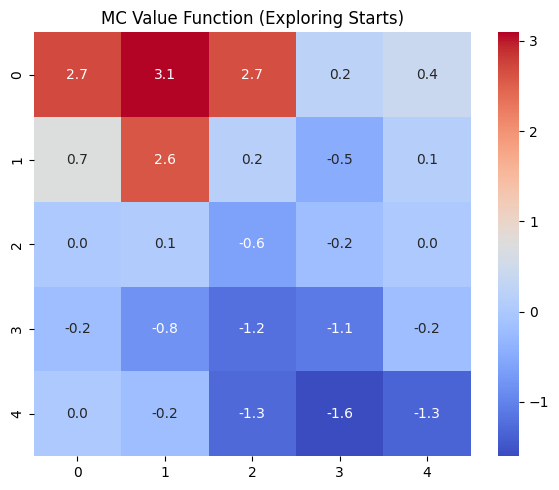

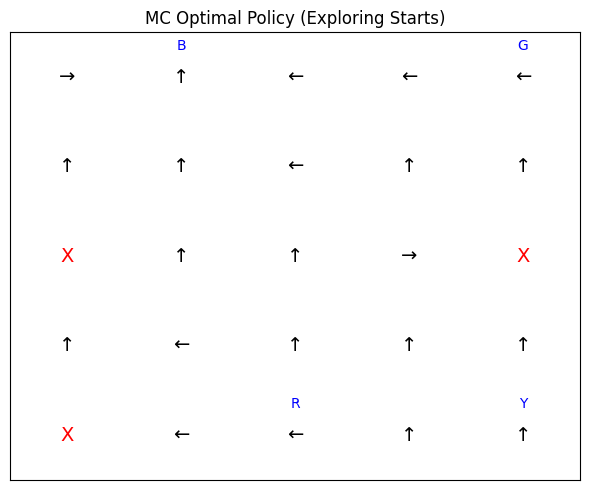

In [57]:
# ---------------- Monte Carlo Control with Exploring Starts ----------------
Q_es, pi_es = mc_control_exploring_starts()

V_es = np.max(Q_es, axis=1).reshape(GRID_SIZE, GRID_SIZE)

# Value Heatmap (Exploring Starts)
plt.figure(figsize=(6, 5))
sns.heatmap(V_es, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("MC Value Function (Exploring Starts)")
plt.tight_layout()
plt.show()

# Policy Arrows (Exploring Starts) - X marks terminal states
plt.figure(figsize=(6, 5))
grid_pi = np.array([ACTION_NAMES[a] for a in pi_es]).reshape(GRID_SIZE, GRID_SIZE)
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        if (i, j) in TERMINAL_STATES:
            plt.text(j + 0.5, i + 0.5, "X", ha='center', va='center', fontsize=14, color='red')
        else:
            plt.text(j + 0.5, i + 0.5, grid_pi[i, j], ha='center', va='center', fontsize=14, color='black')
for (i, j), label in {BLUE: 'B', GREEN: 'G', RED: 'R', YELLOW: 'Y'}.items():
    plt.text(j + 0.5, i + 0.2, label, ha='center', fontsize=10, color='blue')
plt.title("MC Optimal Policy (Exploring Starts)")
plt.xlim(0, GRID_SIZE)
plt.ylim(0, GRID_SIZE)
plt.gca().invert_yaxis()
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

**Monte Carlo Control with ε-Soft Policy**

In [58]:
def mc_control_epsilon_soft(num_episodes=10000, epsilon=0.1):
    Q = np.zeros((NUM_STATES, len(ACTIONS)))
    returns_count = np.zeros((NUM_STATES, len(ACTIONS)))

    # Initialize policy as uniform
    policy = np.ones((NUM_STATES, len(ACTIONS))) / len(ACTIONS)

    for _ in range(num_episodes):
        states, actions, rewards = generate_episode(policy=sample_from_policy(policy), exploring_starts=False)
        G, visited = 0, set()
        skip_propagation = False  # block backward flow only

        for t in reversed(range(len(states))):
            s, a, r = states[t], actions[t], rewards[t]
            coords = to_coords(s)

            G = GAMMA * G + r

            # ✅ Always update BLUE or GREEN (they should learn their own value)
            if coords in [BLUE, GREEN]:
                skip_propagation = True  # but prevent earlier states from absorbing G

            # ✅ Skip backpropagating the reward to states before BLUE/GREEN
            elif skip_propagation:
                continue

            if (s, a) not in visited:
                visited.add((s, a))
                returns_count[s, a] += 1
                Q[s, a] += (G - Q[s, a]) / returns_count[s, a]

                # ε-soft policy update
                best_action = np.argmax(Q[s])
                for a_i in range(len(ACTIONS)):
                    policy[s][a_i] = (
                        1 - epsilon + (epsilon / len(ACTIONS)) if a_i == best_action else epsilon / len(ACTIONS)
                    )




    return Q, policy


In [59]:
def sample_from_policy(policy_probs):
    def policy_fn(s):
        return np.random.choice(len(ACTIONS), p=policy_probs[s])
    return policy_fn


In [60]:
def generate_episode(policy=None, exploring_starts=False):
    states, actions, rewards = [], [], []

    # Start from random non-terminal state
    while True:
        s = random.randint(0, NUM_STATES - 1)
        if to_coords(s) not in TERMINAL_STATES:
            break

    # First action
    a = random.choice(range(len(ACTIONS))) if exploring_starts else (
        policy(s) if policy is not None else random.choice(range(len(ACTIONS)))
    )

    done, step_count = False, 0
    while not done and step_count < MAX_STEPS:
        states.append(s)
        actions.append(a)
        s_next, r, done = step(s, ACTIONS[a])
        rewards.append(r)

        if not done:
            a = policy(s_next) if policy is not None else random.choice(range(len(ACTIONS)))
        s = s_next
        step_count += 1

    return states, actions, rewards


In [61]:
Q_eps, pi_eps = mc_control_epsilon_soft(num_episodes=10000, epsilon=0.1)
V_eps = np.max(Q_eps, axis=1).reshape(GRID_SIZE, GRID_SIZE)

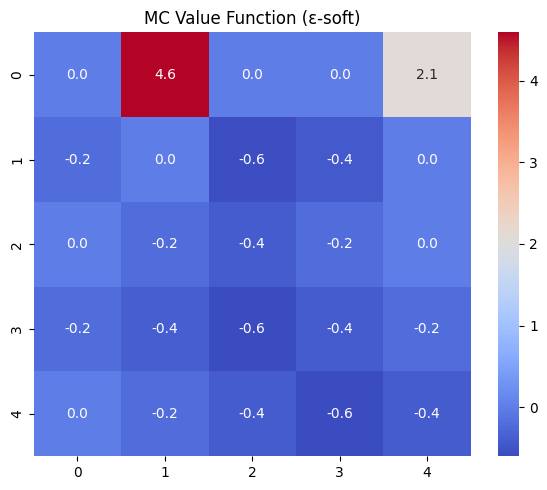

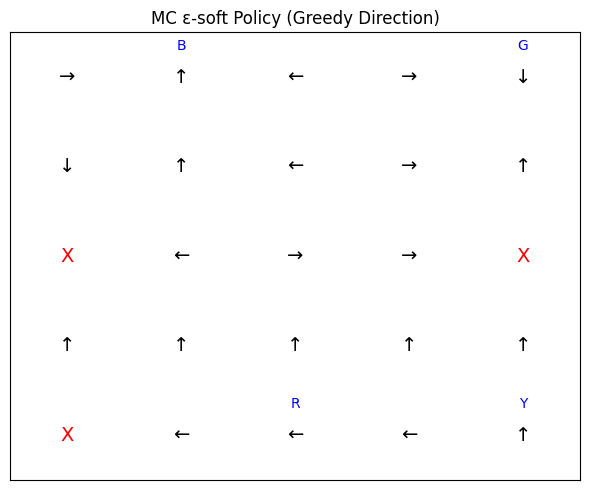

In [62]:
# Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(V_eps, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("MC Value Function (ε-soft)")
plt.tight_layout()
plt.show()

# Policy Arrows (ε-soft) - X marks terminal states
plt.figure(figsize=(6, 5))
# Convert soft policy to greedy for plotting
greedy_actions = np.argmax(pi_eps, axis=1)
grid_pi = np.array([ACTION_NAMES[a] for a in greedy_actions]).reshape(GRID_SIZE, GRID_SIZE)

# Draw arrows or Xs
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        if (i, j) in TERMINAL_STATES:
            plt.text(j + 0.5, i + 0.5, "X", ha='center', va='center', fontsize=14, color='red')
        else:
            plt.text(j + 0.5, i + 0.5, grid_pi[i, j], ha='center', va='center', fontsize=14, color='black')

# Annotate labels
for (i, j), label in {BLUE: 'B', GREEN: 'G', RED: 'R', YELLOW: 'Y'}.items():
    plt.text(j + 0.5, i + 0.2, label, ha='center', fontsize=10, color='blue')

plt.title("MC ε-soft Policy (Greedy Direction)")
plt.xlim(0, GRID_SIZE)
plt.ylim(0, GRID_SIZE)
plt.gca().invert_yaxis()
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()

In [63]:
V_eps

array([[ 0.        ,  4.59437517,  0.        ,  0.        ,  2.08772571],
       [-0.2       ,  0.        , -0.5705    , -0.43999227,  0.        ],
       [ 0.        , -0.2       , -0.40247673, -0.2       ,  0.        ],
       [-0.2       , -0.39577008, -0.59135774, -0.40883277, -0.2       ],
       [ 0.        , -0.2       , -0.40504037, -0.60246345, -0.41520906]])

**Comparison**

🌟 MC Value Exploring Start: Max value = 3.09 at state(s): [(0, 1)]
🌟 State-Value Function from MC (ε-soft): Max value = 4.59 at state(s): [(0, 1)]


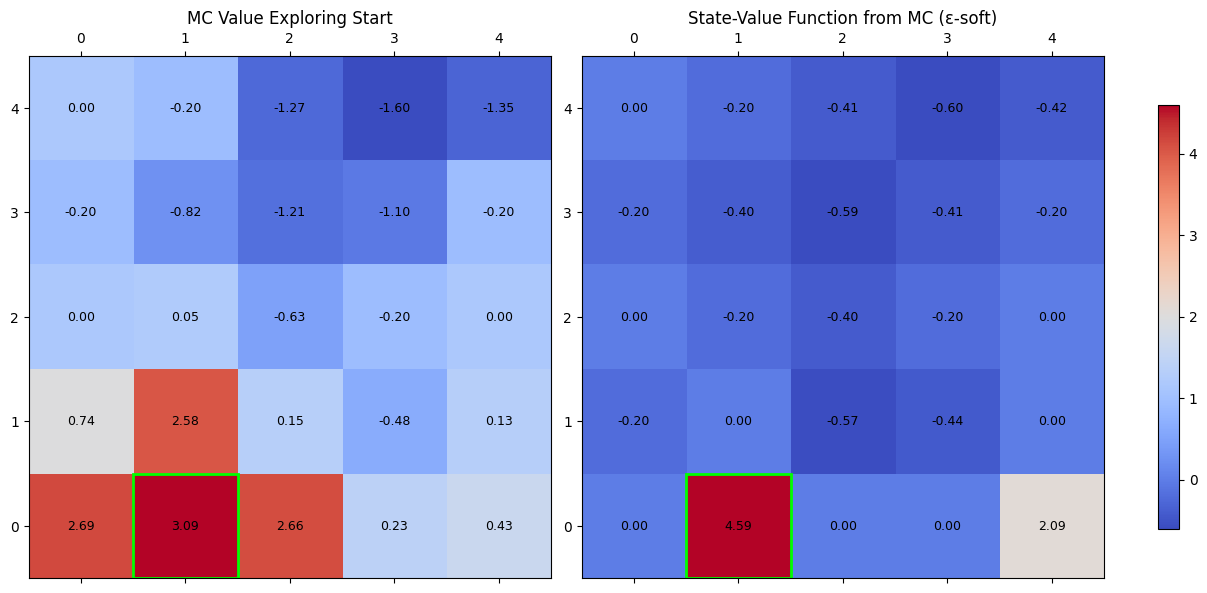

In [64]:
plot_two_value_grids(V_es, V_eps,
                     "MC Value Exploring Start",
                     "State-Value Function from MC (ε-soft)")

In [65]:
def plot_mc_policy_comparison(policy1, policy2, title1="Exploring Starts", title2="ε-soft"):
    action_symbols = ['↑', '↓', '←', '→']
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    for idx, (policy, title, ax) in enumerate(zip([policy1, policy2], [title1, title2], axes)):
        ax.set_title(title, fontsize=14)
        ax.set_xticks(np.arange(GRID_SIZE))
        ax.set_yticks(np.arange(GRID_SIZE))
        ax.set_xticklabels(np.arange(GRID_SIZE))
        ax.set_yticklabels(np.arange(GRID_SIZE))
        ax.grid(True)
        ax.invert_yaxis()

        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                s = (i, j)
                s_idx = i * GRID_SIZE + j  # ← convert (i, j) to state index

                if s in TERMINAL_STATES:
                    ax.text(j, i, "**", ha='center', va='center', fontsize=14, color='black')
                elif s == BLUE:
                    ax.text(j, i, "B", ha='center', va='center', fontsize=14, color='blue')
                elif s == GREEN:
                    ax.text(j, i, "G", ha='center', va='center', fontsize=14, color='green')
                elif s == RED:
                    ax.text(j, i, "R", ha='center', va='center', fontsize=14, color='red')
                elif s == YELLOW:
                    ax.text(j, i, "Y", ha='center', va='center', fontsize=14, color='orange')
                else:
                    best_actions = np.argwhere(policy[s_idx] == np.max(policy[s_idx])).flatten()
                    text = "".join([action_symbols[a] for a in best_actions])
                    ax.text(j, i, text, ha='center', va='center', fontsize=14, color='gray')

    plt.suptitle("Monte Carlo Policy Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()


In [66]:
def convert_greedy_to_soft(pi_greedy, num_actions):
    policy = np.zeros((len(pi_greedy), num_actions))
    for s, a in enumerate(pi_greedy):
        policy[s, a] = 1.0
    return policy

pi_es_= convert_greedy_to_soft(pi_es, len(ACTIONS))


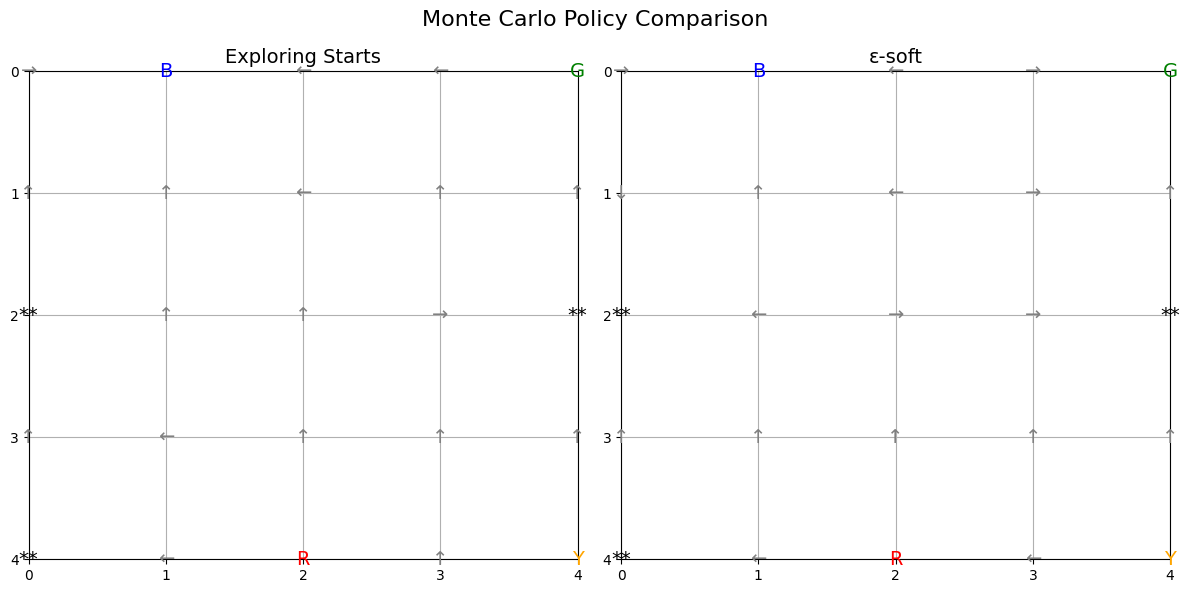

In [67]:
plot_mc_policy_comparison(pi_es_, pi_eps)


**Note**

Slight differences exist between the policies learned by MC Exploring Starts and ε-soft Monte Carlo methods. These arise naturally from the stochastic elements in both algorithms and the presence of multiple near-optimal action sequences.
Importantly, both policies consistently prioritize reaching rewarding states such as BLUE (0,1) while effectively avoiding terminal states.
Thus, although specific actions may vary across some states, the overall strategic behavior of both policies remains aligned.

**2. Now use a behaviour policy with equiprobable moves to learn an optimal policy. Note here the dynamics of the world are known exactly, so you can actually compute the importance weights needed for this.**

In [68]:
MAX_STEPS = 50       # shorter episodes for stability
EPISODES = 10000     # fewer episodes to keep values bounded
def to_index(i, j): return i * GRID_SIZE + j
def to_coords(s): return divmod(s, GRID_SIZE)

# Step function with BLUE/GREEN teleport logic and terminal states
def step(state, action):
    if to_coords(state) in TERMINAL_STATES:
        return state, 0, True

    i, j = to_coords(state)
    ni, nj = i + action[0], j + action[1]
    reward, done = 0, False

    if (i, j) == BLUE:
        return to_index(*RED), 5, False

    if (i, j) == GREEN:
        target = RED if np.random.rand() < 0.5 else YELLOW
        return to_index(*target), 2.5, False

    if not (0 <= ni < GRID_SIZE and 0 <= nj < GRID_SIZE) and (i, j) not in [BLUE, GREEN]:
        return state, -0.5, False

    if 0 <= ni < GRID_SIZE and 0 <= nj < GRID_SIZE:
        next_state = to_index(ni, nj)
        reward = -0.2
        done = (ni, nj) in TERMINAL_STATES
        return next_state, reward, done

    return state, reward, done



In [69]:
# ---------------- Stable Off-Policy MC with Per-Decision IS ----------------
def off_policy_mc_stable(episodes=EPISODES):
    """
    Off-Policy Monte Carlo Control using Per-Decision Importance Sampling (PDIS).
    - Behavior policy: uniform random (1/4 each).
    - Target policy: greedy w.r.t Q.
    - Uses decaying α to stabilize the highest values over time.
    """
    Q = { s: np.zeros(len(ACTIONS)) for s in range(NUM_STATES) }
    visit_counts = { (s,a): 0 for s in range(NUM_STATES) for a in range(len(ACTIONS)) }
    target_policy = { s: np.ones(len(ACTIONS)) / len(ACTIONS) for s in range(NUM_STATES) }

    for ep in range(episodes):
        episode = []
        valid_states = [to_index(i,j) for i in range(GRID_SIZE) for j in range(GRID_SIZE)
                        if (i,j) not in TERMINAL_STATES]
        state = random.choice(valid_states)
        action_idx = random.choice(range(len(ACTIONS)))
        steps = 0

        # Generate episode under uniform behavior policy
        while True:
            new_state, reward, done = step(state, ACTIONS[action_idx])
            episode.append((state, action_idx, reward))
            steps += 1
            if done or steps >= MAX_STEPS:
                break
            action_idx = random.choice(range(len(ACTIONS)))
            state = new_state

        # Backward pass: per-decision importance sampling
        G = 0.0
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = GAMMA * G + r

            # Greedy action check for target policy
            best_a = np.argmax(Q[s])
            rho = 1.0 if a == best_a else 0.0
            w_t = rho / 0.25  # behavior policy is uniform

            # Decaying learning rate: α = 1 / (1 + visits)
            visit_counts[(s,a)] += 1
            alpha = 1.0 / (1.0 + visit_counts[(s,a)])

            # Q update
            Q[s][a] += alpha * w_t * (G - Q[s][a])

            # Update greedy policy
            target_policy[s] = np.zeros(len(ACTIONS))
            target_policy[s][best_a] = 1.0

    return Q, target_policy

# ---------------- Helpers ----------------
def compute_state_values(Q_dict):
    values = np.zeros((GRID_SIZE, GRID_SIZE))
    for s, q_vals in Q_dict.items():
        i,j = to_coords(s)
        values[i,j] = np.max(q_vals)
    return values

def plot_value_function_no_arrows(values, title=""):
    plt.figure(figsize=(6, 5))
    sns.heatmap(values, annot=True, fmt=".1f", cmap="coolwarm", cbar=True)

    # Mark terminal and special squares
    for i,j in TERMINAL_STATES:
        plt.text(j+0.5, i+0.5, "X", ha='center', va='center', fontsize=14, color='red')
    for (i,j), label in {BLUE:'B', GREEN:'G', RED:'R', YELLOW:'Y'}.items():
        plt.text(j+0.5, i+0.5, label, ha='center', va='center', fontsize=12, color='blue')

    plt.title(title)
    plt.xlim(0, GRID_SIZE); plt.ylim(0, GRID_SIZE)
    plt.gca().invert_yaxis(); plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.show()



In [70]:
# ---------------- Train and Visualize ----------------
Q_stable, policy_stable = off_policy_mc_stable(episodes=EPISODES)
V_stable = compute_state_values(Q_stable)



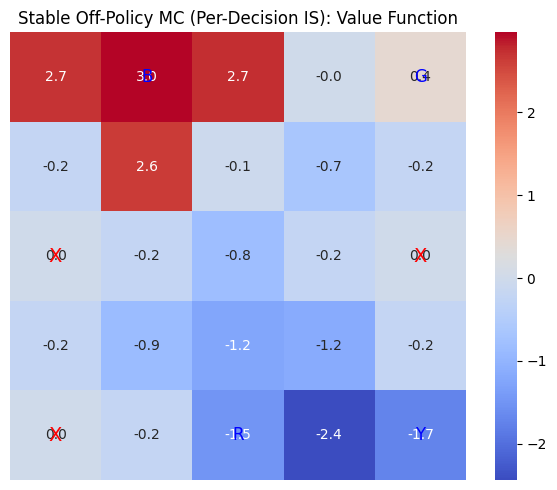


Stable Off-Policy MC (Per-Decision IS) Policy Grid:


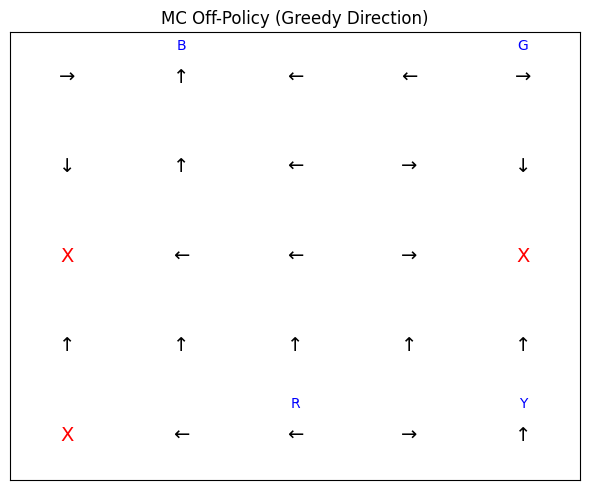

In [71]:
plot_value_function_no_arrows(V_stable,
                              title="Stable Off-Policy MC (Per-Decision IS): Value Function")

print("\nStable Off-Policy MC (Per-Decision IS) Policy Grid:")

# Policy Arrows Off-Policy MC - X marks terminal states
plt.figure(figsize=(6, 5))

# Convert dict-based soft policy to greedy action per state
greedy_actions = np.array([
    np.argmax(policy_stable[to_index(i, j)])
    if (i, j) not in TERMINAL_STATES else -1
    for i in range(GRID_SIZE) for j in range(GRID_SIZE)
])

grid_pi = np.array([
    "X" if a == -1 else ACTION_NAMES[a]
    for a in greedy_actions
]).reshape(GRID_SIZE, GRID_SIZE)

# Draw arrows or Xs
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        plt.text(j + 0.5, i + 0.5, grid_pi[i, j], ha='center', va='center',
                 fontsize=14, color='red' if grid_pi[i, j] == "X" else 'black')

# Annotate special states
for (i, j), label in {BLUE: 'B', GREEN: 'G', RED: 'R', YELLOW: 'Y'}.items():
    plt.text(j + 0.5, i + 0.2, label, ha='center', fontsize=10, color='blue')

plt.title("MC Off-Policy (Greedy Direction)")
plt.xlim(0, GRID_SIZE)
plt.ylim(0, GRID_SIZE)
plt.gca().invert_yaxis()
plt.xticks([]); plt.yticks([])
plt.tight_layout()
plt.show()


**Comparison**

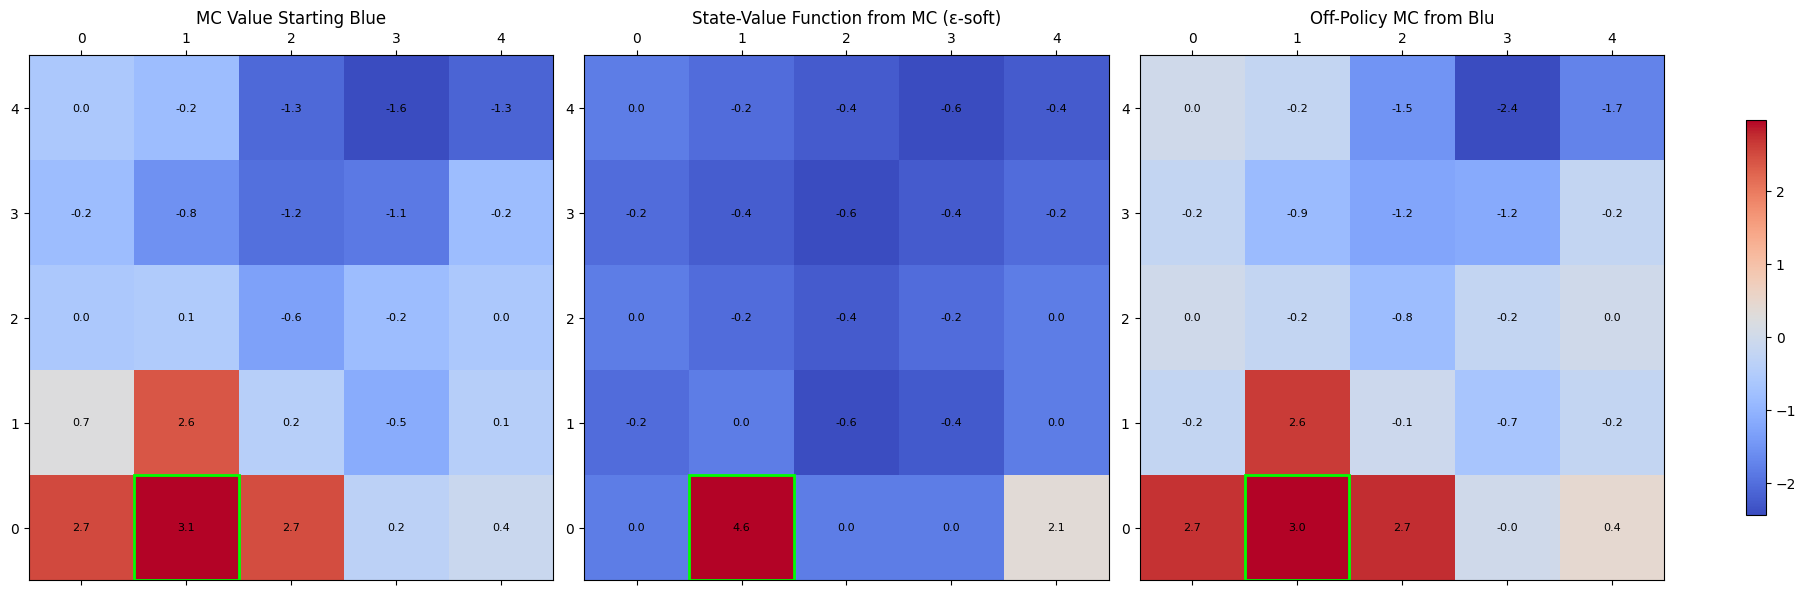

In [72]:
plot_comparative_value_grids(
    [V_es, V_eps, V_stable],
    ["MC Value Starting Blue", "State-Value Function from MC (ε-soft)", "Off-Policy MC from Blu"]
)

In [73]:
def plot_three_mc_policies(policy1, policy2, policy3,
                           title1="Exploring Starts",
                           title2="ε-soft",
                           title3="Off-Policy (IS)"):

    action_symbols = ['↑', '↓', '←', '→']
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    titles = [title1, title2, title3]
    policies = [policy1, policy2, policy3]

    for idx, (policy, title, ax) in enumerate(zip(policies, titles, axes)):
        ax.set_title(title, fontsize=14)
        ax.set_xticks(np.arange(GRID_SIZE))
        ax.set_yticks(np.arange(GRID_SIZE))
        ax.set_xticklabels(np.arange(GRID_SIZE))
        ax.set_yticklabels(np.arange(GRID_SIZE))
        ax.grid(True)
        ax.invert_yaxis()

        for i in range(GRID_SIZE):
            for j in range(GRID_SIZE):
                s = (i, j)
                if s in TERMINAL_STATES:
                    ax.text(j, i, "**", ha='center', va='center', fontsize=14, color='black')
                elif s == BLUE:
                    ax.text(j, i, "B", ha='center', va='center', fontsize=14, color='blue')
                elif s == GREEN:
                    ax.text(j, i, "G", ha='center', va='center', fontsize=14, color='green')
                elif s == RED:
                    ax.text(j, i, "R", ha='center', va='center', fontsize=14, color='red')
                elif s == YELLOW:
                    ax.text(j, i, "Y", ha='center', va='center', fontsize=14, color='orange')
                else:
                    state_idx = to_index(i, j)
                    if isinstance(policy[state_idx], np.ndarray):  # π(s) is a distribution or Q-values
                        best_actions = np.argwhere(policy[state_idx] == np.max(policy[state_idx])).flatten()
                        text = "".join([action_symbols[a] for a in best_actions])
                        ax.text(j, i, text, ha='center', va='center', fontsize=14, color='gray')
                    else:  # π(s) is a single best action index
                        ax.text(j, i, action_symbols[policy[state_idx]], ha='center', va='center', fontsize=14, color='gray')

    plt.suptitle("Monte Carlo Policy Comparison: Exploring Starts vs ε-soft vs Off-Policy (IS)", fontsize=16)
    plt.tight_layout()
    plt.show()


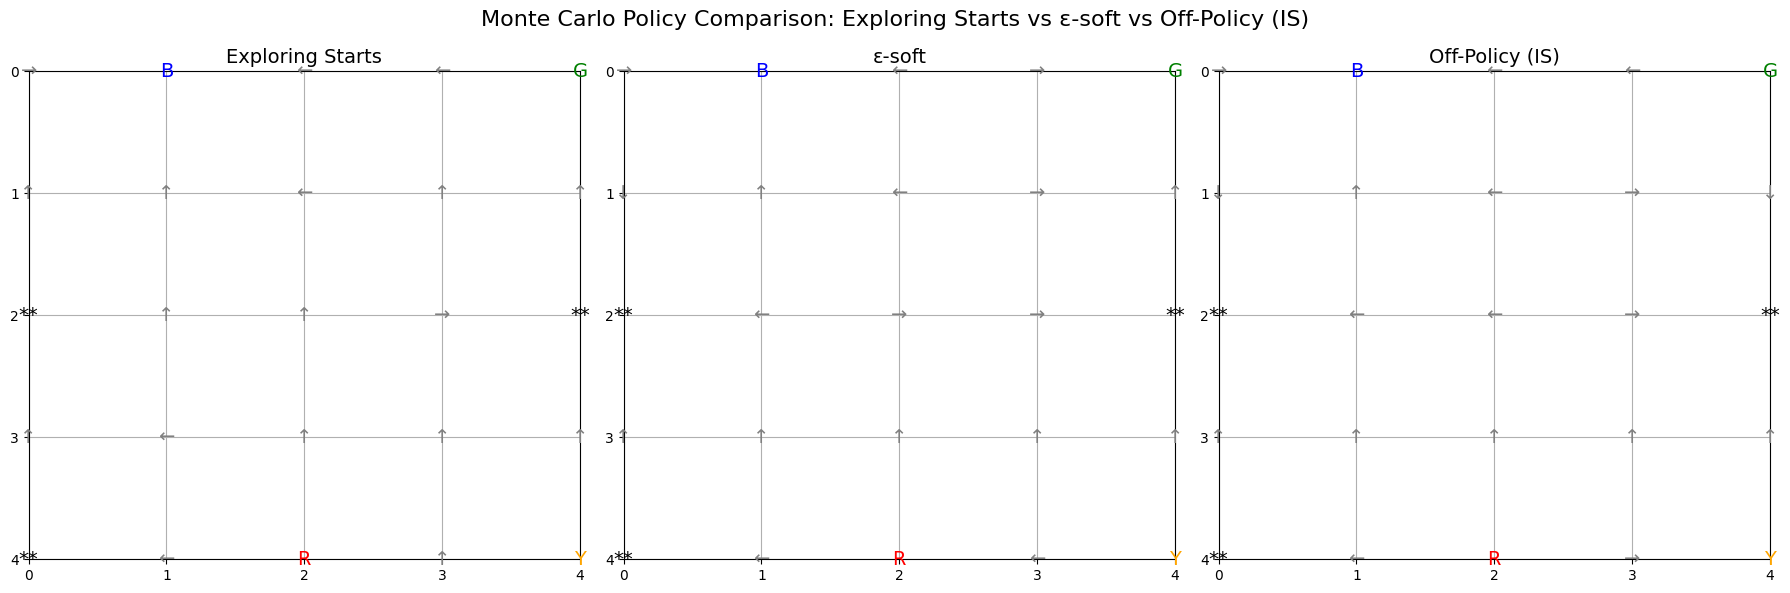

In [74]:
plot_three_mc_policies(pi_es, pi_eps, policy_stable)

**Conclusion:**

All three Monte Carlo control methods successfully converge to policies that prioritize reaching the high-reward BLUE state.

Among them, ε-soft achieves the highest value at the BLUE state (4.6), indicating better reward propagation in this region. This likely results from its broader exploration, which increases the chances of discovering and reinforcing optimal trajectories, despite some stochasticity.

Exploring Starts and Off-policy methods also recognize BLUE as optimal, both converging to a value of 3.1 at that state. Exploring Starts maintains stable learning due to its diverse initialization of episodes, while the Off-policy method performs reliably when the behavior policy is well-aligned with the target policy.

Overall, while all methods identify the BLUE state as optimal, ε-soft yields the most optimistic value estimate in this setting.